In [93]:
import json
import os
import re
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.rcParams["figure.dpi"] = 150
BASE_PATH = os.path.abspath(os.path.join(os.getcwd(), os.pardir))

In [28]:
def parse_json(path):
    data = {}
    for f in os.listdir(path):
        matches = re.search(r"(producer|consumer)_(\d+)_(\d+).json", f)
        if matches:
            run_type, file_size, run = matches.group(1), int(matches.group(2)), int(matches.group(3))
            if run_type not in data:
                data[run_type] = {}
            if file_size not in data[run_type]:
                data[run_type][file_size] = {}
            with open(os.path.join(path, f)) as file_p:
                json_data = json.load(file_p)
                data[run_type][file_size][run] = json_data
    return data

In [39]:
def calc_deltas(data):
    deltas = {}
    for file_size, runs in data['consumer'].items():
        deltas[file_size] = {}
        for run_number, run_data in runs.items():
            deltas[file_size][run_number] = run_data['finishedTime'] - data['producer'][file_size][run_number]['uploadTime']
    return deltas

# S3

In [9]:
S3_BASE_PATH = os.path.join(BASE_PATH, "s3")

## P2P

### Variance

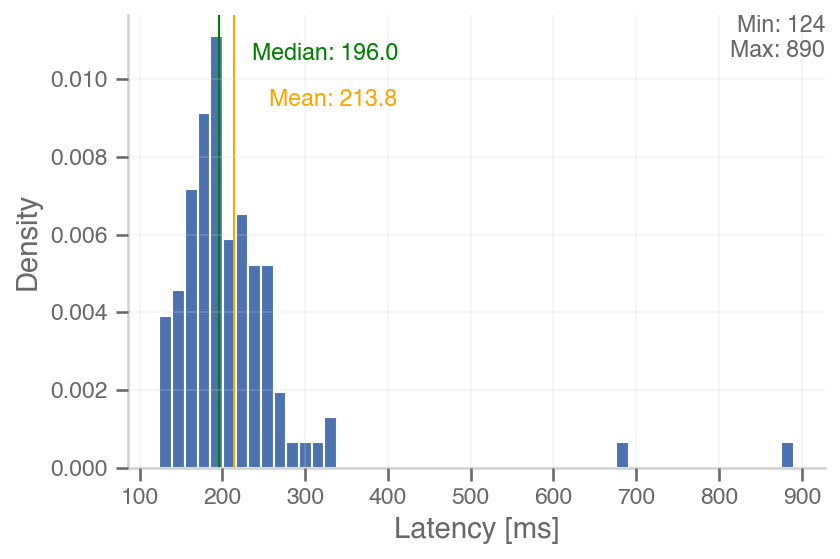

In [135]:
var_base_path = os.path.join(S3_BASE_PATH, "p2p", "latency_distribution", "out")
res = parse_json(var_base_path)
deltas = calc_deltas(res)
delta_vals = list(deltas[10000000].values())
mean = np.mean(delta_vals)
var = np.var(delta_vals)
median = np.median(delta_vals)
plt.hist(delta_vals, density=True, bins=50)
plt.xlabel("Latency [ms]")
plt.ylabel("Density")
plt.axvline(mean, color='orange', linewidth=1)
plt.axvline(median, color='green', linewidth=1)
min_ylim, max_ylim = plt.ylim()
min_xlim, max_xlim = plt.xlim()
plt.text(median * 1.2, max_ylim*0.9, 'Median: {:.1f}'.format(median), color="green", size="x-small")
plt.text(mean * 1.2, max_ylim*0.8, 'Mean: {:.1f}'.format(mean), color="orange", size="x-small")
plt.text(max_xlim, max_ylim, 'Min: {:.0f}\nMax: {:.0f}'.format(np.min(delta_vals), np.max(delta_vals)), size='x-small', horizontalalignment='right', verticalalignment='top')
plt.show()